In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import xgboost as xgb


folder_path = '/content/drive/MyDrive/266 Final Project/David/Data 266'
files = os.listdir(folder_path)
print("Files in directory:")
print(files)


Mounted at /content/drive
Files in directory:
['final_labels_MBIC.csv', 'final_labels_SG1.csv', 'final_labels_SG2.csv', 'final_labels_MBIC.gsheet']


##XGBoost Baseline

In [3]:
#Load
file_path = '/content/drive/MyDrive/266 Final Project/David/Data 266/final_labels_SG2.csv'
data = pd.read_csv(file_path, sep=';', engine='python')

In [ ]:
#Preprocess
data['text'] = data['text'].str.lower()  # Convert to lowercase
data['text'] = data['text'].str.replace('[^a-zA-Z ]', '', regex=True)  # Remove special characters

#label_bias mapping
label_mapping = {'Non-biased': 0, 'Biased': 1}  # Example mapping
data['label_bias_encoded'] = data['label_bias'].map(label_mapping)

#filtering out null rows
data = data.dropna(subset=['text', 'label_bias_encoded'])

print(data.head())


                                                text  \
0  orange is the new black star yael stone is ren...   
1  we have one beautiful law trump recently said ...   
2  immigrants as criminals and eugenics all of wh...   
3  we sounded the alarm in the early months of tr...   
4  black lives matter is essentially a nonfalsifi...   

                                           news_link     outlet  \
0  https://www.foxnews.com/entertainment/australi...   Fox News   
1  https://www.alternet.org/2020/06/law-and-order...   Alternet   
2  https://www.nbcnews.com/news/latino/after-step...      MSNBC   
3  https://www.alternet.org/2019/07/fox-news-has-...   Alternet   
4  http://feedproxy.google.com/~r/breitbart/~3/-v...  Breitbart   

               topic   type  label_bias  \
0        environment  right  Non-biased   
1        gun control   left      Biased   
2  white-nationalism   left      Biased   
3  white-nationalism   left      Biased   
4  marriage-equality    NaN      Biased   

 

In [ ]:
#Vectorizing TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))  # Unigrams and bigrams
X = vectorizer.fit_transform(data['text']).toarray()

#Labels
y = data['label_bias_encoded']

#train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")


Train size: (2938, 5000), Test size: (735, 5000)


In [ ]:
#Converting data to DMatrix format (optimized for XGBoost)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

#parameters for XGBoost
params = {
    'objective': 'multi:softmax',  #Softmax for multi-class classification
    'num_class': len(np.unique(y)),  #num_classes
    'eval_metric': 'mlogloss',      #log loss
    'max_depth': 6,                 #tree depth max
    'eta': 0.3,                     #LR
    'nthread': 4,                   #Threads
    'seed': 42                      #Random seed
}

#Train
num_round = 100  #boosting rounds
bst = xgb.train(params, dtrain, num_round)


Accuracy: 0.7210884353741497

Classification Report:
              precision    recall  f1-score   support

         0.0       0.74      0.69      0.72       376
         1.0       0.70      0.75      0.72       359

    accuracy                           0.72       735
   macro avg       0.72      0.72      0.72       735
weighted avg       0.72      0.72      0.72       735



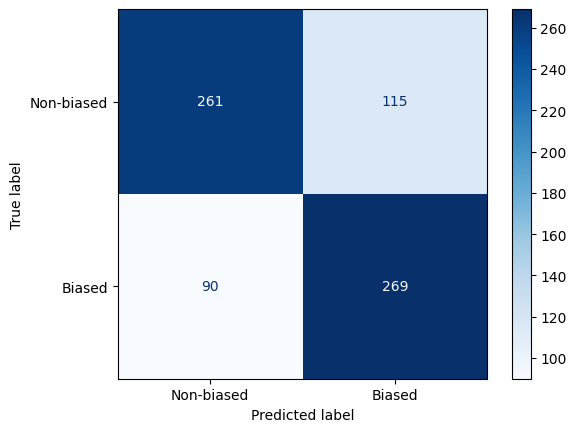

In [ ]:
#prediction
y_pred = bst.predict(dtest).astype(int)

#accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

#classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

#Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-biased', 'Biased'])
disp.plot(cmap='Blues')


In [ ]:
from sklearn.model_selection import GridSearchCV

#parameter grid
param_grid = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [50, 100, 200],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

#initializing XGBoost model
xgb_clf = xgb.XGBClassifier(objective='multi:softmax', num_class=len(np.unique(y)), random_state=42)

#grid search
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, scoring='accuracy', cv=3, verbose=1)
grid_search.fit(X_train, y_train)

#optimal params
print("Best parameters:", grid_search.best_params_)

#training best model
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

#results
y_pred = best_model.predict(X_test)
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}

Accuracy: 0.7129251700680272

Classification Report:
              precision    recall  f1-score   support

         0.0       0.74      0.68      0.71       376
         1.0       0.69      0.75      0.72       359

    accuracy                           0.71       735
   macro avg       0.71      0.71      0.71       735
weighted avg       0.72      0.71      0.71       735



# Log Regression

In [ ]:
import pandas as pd

file_path = '/content/drive/MyDrive/266 Final Project/David/Data 266/final_labels_SG2.csv'

try:
    data = pd.read_csv(
        file_path,
        sep=';',
        quoting=3,
        engine='python',
        on_bad_lines='skip'
    )
    print("File loaded successfully!")
    print(data.head())
except pd.errors.ParserError as e:
    print(f"ParserError: {e}")
except Exception as e:
    print(f"Error: {e}")


File loaded successfully!
                                                text  \
0  """Orange Is the New Black"" star Yael Stone i...   
1  """We have one beautiful law,"" Trump recently...   
2  ...immigrants as criminals and eugenics, all o...   
3  ...we sounded the alarm in the early months of...   
4  [Black Lives Matter] is essentially a non-fals...   

                                           news_link     outlet  \
0  https://www.foxnews.com/entertainment/australi...   Fox News   
1  https://www.alternet.org/2020/06/law-and-order...   Alternet   
2  https://www.nbcnews.com/news/latino/after-step...      MSNBC   
3  https://www.alternet.org/2019/07/fox-news-has-...   Alternet   
4  http://feedproxy.google.com/~r/breitbart/~3/-v...  Breitbart   

               topic   type  label_bias  \
0        environment  right  Non-biased   
1        gun control   left      Biased   
2  white-nationalism   left      Biased   
3  white-nationalism   left      Biased   
4  marriage-equalit

In [ ]:
#check for missing values
print(data.isnull().sum())

#summary unique values in categorical columns
for col in ['label_bias', 'label_opinion', 'type']:
    print(f"{col} unique values: {data[col].unique()}")


text               0
news_link         35
outlet             3
topic              3
type             997
label_bias         3
label_opinion      3
biased_words       3
dtype: int64
label_bias unique values: ['Non-biased' 'Biased' 'No agreement' None]
label_opinion unique values: ['Entirely factual' 'Somewhat factual but also opinionated'
 'Expresses writer’s opinion' 'No agreement' None]
type unique values: ['right' 'left' nan 'center' None]


In [ ]:
from sklearn.preprocessing import LabelEncoder

#encode 'label_bias' (target variable for classification)
data['label_bias_encoded'] = LabelEncoder().fit_transform(data['label_bias'])

#check encoded labels
print(data[['label_bias', 'label_bias_encoded']].drop_duplicates())


        label_bias  label_bias_encoded
0       Non-biased                   2
1           Biased                   0
2125  No agreement                   1
2216          None                   3


In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

#Preprocessing
def preprocess_text(text):
    text = re.sub(r'\W', ' ', str(text))  #remove special characters
    text = text.lower()  #convert to lowercase
    text = re.sub(r'\s+', ' ', text)  #remove extra spaces
    text = ' '.join([word for word in text.split() if word not in stop_words])  #remove stopwords
    return text

data['cleaned_text'] = data['text'].apply(preprocess_text)

#check cleaned text
print(data['cleaned_text'].head())


0    orange new black star yael stone renouncing u ...
1    one beautiful law trump recently said characte...
2    immigrants criminals eugenics considered fring...
3    sounded alarm early months trump presidency pr...
4    black lives matter essentially non falsifiable...
Name: cleaned_text, dtype: object


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
tfidf = TfidfVectorizer(max_features=5000)  #Adjusting the number of features as needed
X_tfidf = tfidf.fit_transform(data['cleaned_text'])

#Converting to DataFrame for easier inspection
X_tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())
print(X_tfidf_df.head())


   000   10  100   11   12   13   14   15  150   16  ...  yorkers  young  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...      0.0    0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...      0.0    0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...      0.0    0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...      0.0    0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...      0.0    0.0   

   younger  youngsters  youth  youtube  zealand  zero  zone  zoom  
0      0.0         0.0    0.0      0.0      0.0   0.0   0.0   0.0  
1      0.0         0.0    0.0      0.0      0.0   0.0   0.0   0.0  
2      0.0         0.0    0.0      0.0      0.0   0.0   0.0   0.0  
3      0.0         0.0    0.0      0.0      0.0   0.0   0.0   0.0  
4      0.0         0.0    0.0      0.0      0.0   0.0   0.0   0.0  

[5 rows x 5000 columns]


In [ ]:
from sklearn.model_selection import train_test_split

#features: TF-IDF representations
X = X_tfidf

#Target: Encoded bias labels
y = data['label_bias_encoded']

#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)


Training data shape: (2920, 5000)
Testing data shape: (730, 5000)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Train the model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

# Evaluate performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.7273972602739726
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.71      0.71       340
           2       0.75      0.74      0.74       388
           3       0.00      0.00      0.00         2

    accuracy                           0.73       730
   macro avg       0.48      0.49      0.48       730
weighted avg       0.73      0.73      0.73       730



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


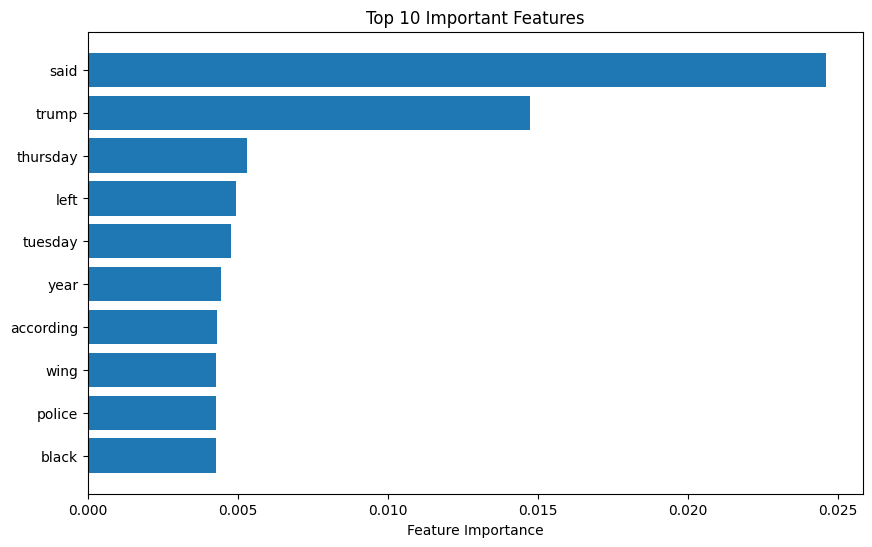

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Feature importance
importances = rf_model.feature_importances_
indices = np.argsort(importances)[-10:]  # Top 10 features

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [tfidf.get_feature_names_out()[i] for i in indices])
plt.xlabel("Feature Importance")
plt.title("Top 10 Important Features")
plt.show()


In [ ]:
print(data['label_bias_encoded'].value_counts())


label_bias_encoded
2    1857
0    1789
3       3
1       1
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'saga']
}
grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best parameters: {'C': 1, 'solver': 'liblinear'}


In [ ]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_tfidf = tfidf.fit_transform(data['cleaned_text'])


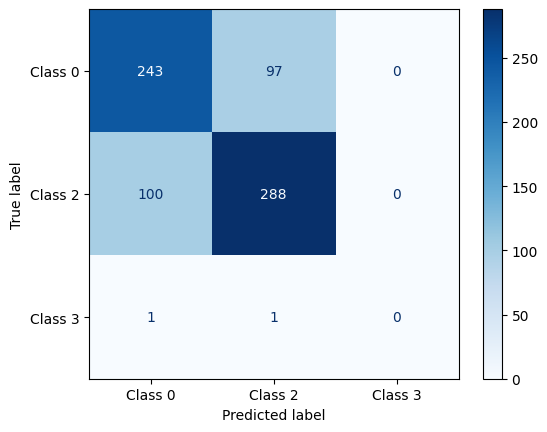

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=['Class 0', 'Class 2', 'Class 3']).plot(cmap='Blues')
plt.show()
